<a href="https://colab.research.google.com/github/akhundMurad/MachineLearning/blob/main/practice/Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8: Introduction to CNN

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:37<00:00, 22.1MB/s]
100% 812M/812M [00:37<00:00, 22.6MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
import os, shutil, pathlib


original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
categories = ("cat", "dog")

def make_subset(subset_name, start_index, end_index):
    for category in categories:
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [
            f"{category}.{i}.jpg"
            for i in range(start_index, end_index)
        ]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [8]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory


train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32,
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 13s 95ms/step - loss: 0.7034 - accuracy: 0.5100 - val_loss: 0.6919 - val_accuracy: 0.5530
Epoch 2/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6960 - accuracy: 0.5355 - val_loss: 0.6905 - val_accuracy: 0.5090
Epoch 3/30
63/63 [==============================] - 6s 87ms/step - loss: 0.6909 - accuracy: 0.5510 - val_loss: 0.6961 - val_accuracy: 0.5250
Epoch 4/30
63/63 [==============================] - 5s 77ms/step - loss: 0.6622 - accuracy: 0.6265 - val_loss: 0.6757 - val_accuracy: 0.6010
Epoch 5/30
63/63 [==============================] - 4s 67ms/step - loss: 0.6198 - accuracy: 0.6540 - val_loss: 0.6051 - val_accuracy: 0.6610
Epoch 6/30
63/63 [==============================] - 6s 89ms/step - loss: 0.5860 - accuracy: 0.6930 - val_loss: 0.6558 - val_accuracy: 0.6210
Epoch 7/30
63/63 [==============================] - 4s 56ms/step - loss: 0.5554 - accuracy: 0.7145 - val_loss: 0.6546 - val_accuracy: 0.6440
Epoch 8/30
6

In [11]:
import matplotlib.pyplot as plt


def show_plots(history):
    accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]
    loss = history["loss"]
    val_loss = history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Accuracy on the training step")
    plt.plot(epochs, val_accuracy, "b", label="Accuracy on the validation step")
    plt.title("Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Loss on the training step")
    plt.plot(epochs, val_loss, "b", label="Loss on the validation step")
    plt.title("Loss")
    plt.legend()
    plt.show()

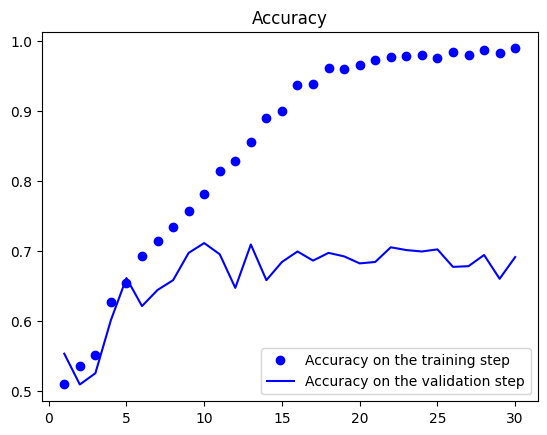

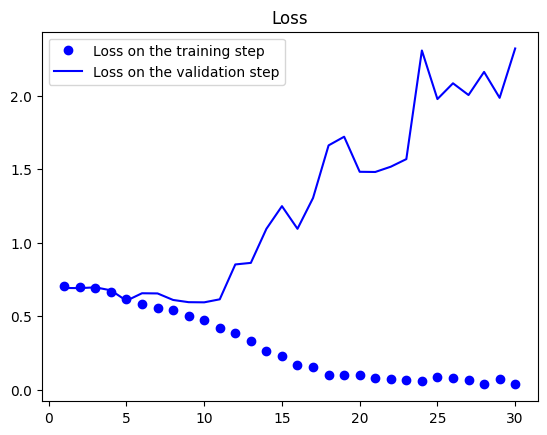

In [12]:
show_plots(history.history)

In [13]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 33ms/step - loss: 0.6002 - accuracy: 0.7180
Test accuracy: 0.718


In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

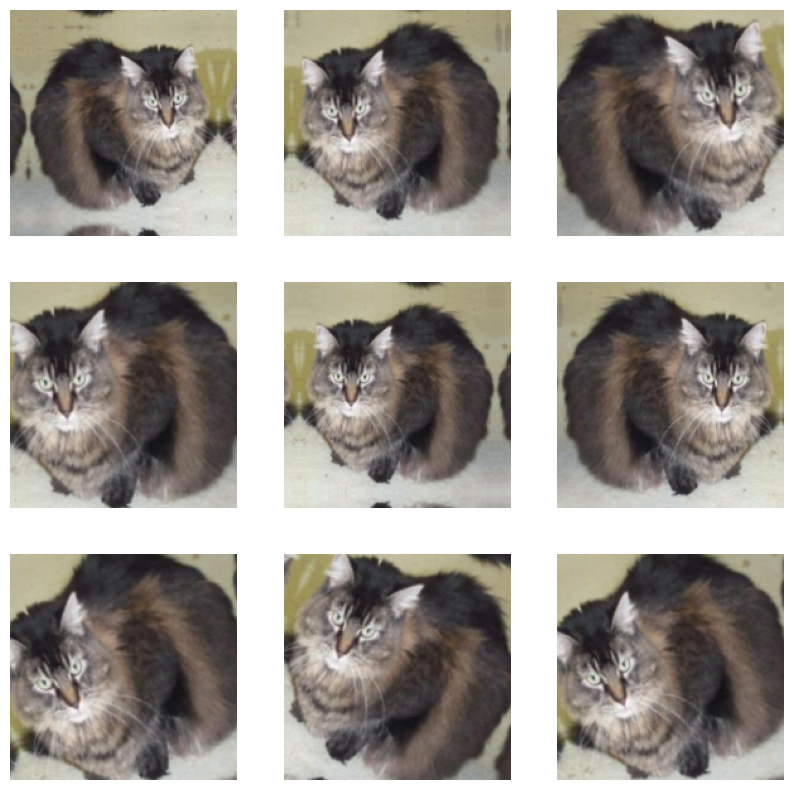

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 8s 63ms/step - loss: 0.7087 - accuracy: 0.4845 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6972 - accuracy: 0.5025 - val_loss: 0.6919 - val_accuracy: 0.5180
Epoch 3/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6949 - accuracy: 0.5205 - val_loss: 0.6922 - val_accuracy: 0.5050
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6892 - accuracy: 0.5485 - val_loss: 0.6917 - val_accuracy: 0.5080
Epoch 5/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6836 - accuracy: 0.5595 - val_loss: 0.6897 - val_accuracy: 0.5490
Epoch 6/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6586 - accuracy: 0.6325 - val_loss: 0.6531 - val_accuracy: 0.6120
Epoch 7/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6355 - accuracy: 0.6495 - val_loss: 0.6090 - val_accuracy: 0.6650
Epoch 

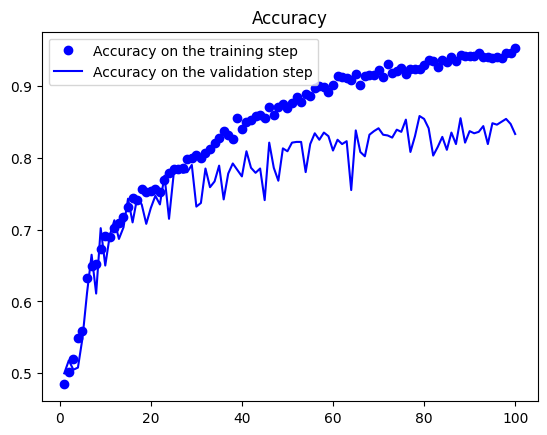

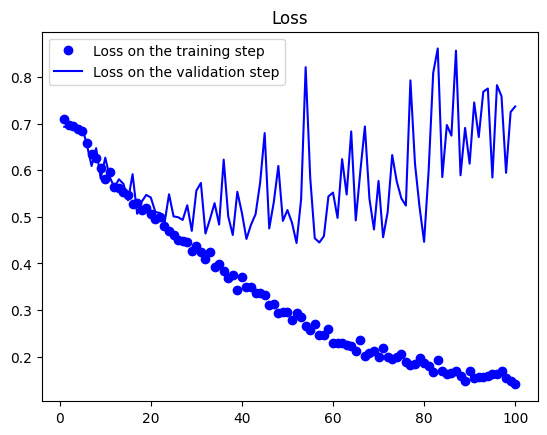

In [18]:
show_plots(history.history)

In [19]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 30ms/step - loss: 0.4594 - accuracy: 0.8115
Test accuracy: 0.812


In [21]:
import numpy as np


conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3),
)


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 0s 21ms/step


(2000, 5, 5, 512)

In [22]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 17.1657 - accuracy: 0.9220 - val_loss: 7.0424 - val_accuracy: 0.9620
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.9066 - accuracy: 0.9695 - val_loss: 5.3668 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.8799 - accuracy: 0.9870 - val_loss: 12.7511 - val_accuracy: 0.9430
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 1.2947 - accuracy: 0.9910 - val_loss: 7.5720 - val_accuracy: 0.9660
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.1097 - accuracy: 0.9910 - val_loss: 4.4506 - val_accuracy: 0.9820
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5169 - accuracy: 0.9955 - val_loss: 5.8802 - val_accuracy: 0.9740
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1.0440 - accuracy: 0.9935 - val_loss: 5.3293 - val_accuracy: 0.9750
Epoch 8/20
63/63 

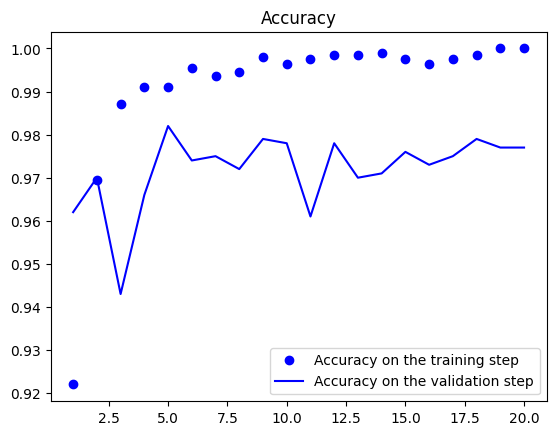

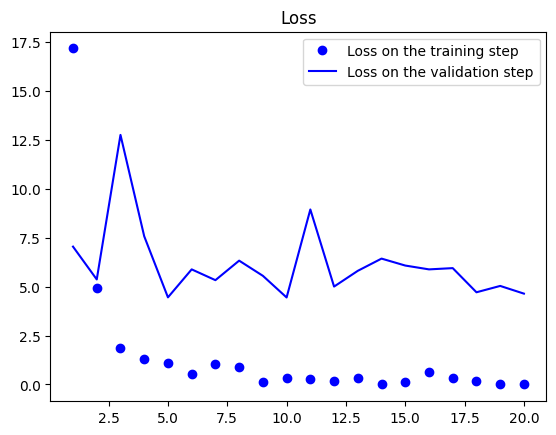

In [23]:
show_plots(history.history)

In [28]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)
conv_base.trainable = False

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

Epoch 1/50
63/63 [==============================] - 11s 155ms/step - loss: 16.5564 - accuracy: 0.8925 - val_loss: 11.4475 - val_accuracy: 0.9420
Epoch 2/50
63/63 [==============================] - 9s 144ms/step - loss: 6.9307 - accuracy: 0.9440 - val_loss: 9.9830 - val_accuracy: 0.9530
Epoch 3/50
63/63 [==============================] - 12s 183ms/step - loss: 5.0226 - accuracy: 0.9630 - val_loss: 4.7900 - val_accuracy: 0.9690
Epoch 4/50
63/63 [==============================] - 10s 148ms/step - loss: 4.3340 - accuracy: 0.9615 - val_loss: 5.6676 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 9s 143ms/step - loss: 5.6999 - accuracy: 0.9560 - val_loss: 4.7984 - val_accuracy: 0.9730
Epoch 6/50
63/63 [==============================] - 10s 150ms/step - loss: 4.0714 - accuracy: 0.9680 - val_loss: 4.3596 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 9s 144ms/step - loss: 2.3174 - accuracy: 0.9715 - val_loss: 3.3996 - val_accuracy: 0.9770


In [31]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.h5"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 89ms/step - loss: 1.8047 - accuracy: 0.9785
Test accuracy: 0.979


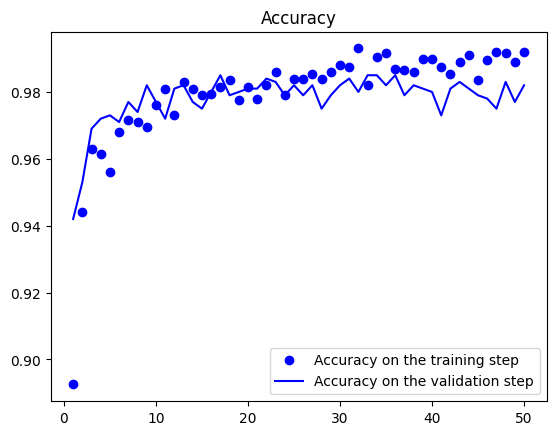

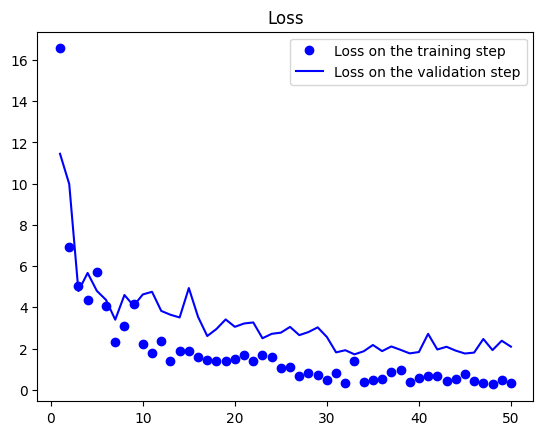

In [32]:
show_plots(history.history)

In [33]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [37]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.9905

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 13s 185ms/step - loss: 0.3330 - accuracy: 0.9905 - val_loss: 1.8639 - val_accuracy: 0.9810
Epoch 2/30
63/63 [==============================] - 9s 144ms/step - loss: 0.2416 - accuracy: 0.9945 - val_loss: 1.8559 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 10s 153ms/step - loss: 0.3956 - accuracy: 0.9920 - val_loss: 1.8534 - val_accuracy: 0.9810
Epoch 4/30
63/63 [==============================] - 10s 149ms/step - loss: 0.2583 - accuracy: 0.9945 - val_loss: 1.8453 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 10s 150ms/step - loss: 0.1901 - accuracy: 0.9950 - val_loss: 1.8473 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 9s 146ms/step - loss: 0.2836 - accuracy: 0.9945 - val_loss: 1.8447 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 9s 143ms/step - loss: 0.2460 - accuracy: 0.9945 - val_loss: 1.8487 - val_accuracy: 0.9810
Epoch 8/30
63

In [38]:
model = keras.models.load_model("fine_tuning.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

63/63 [==============================] - 6s 88ms/step - loss: 1.9074 - accuracy: 0.9780
1.9073930978775024 0.9779999852180481
